In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
sales = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')
sales_conf = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')

In [4]:
sentiment = pd.read_excel('sentiment.xlsx')
sentiment_conf = pd.read_excel('sentiment.xlsx')

In [5]:
sentiment['InteractionDate'] = pd.to_datetime(sentiment['InteractionDate'])
sentiment_conf['InteractionDate'] = pd.to_datetime(sentiment_conf['InteractionDate'])

grouped = sentiment.set_index(['InteractionDate'])
goruped_conf = sentiment_conf.set_index(['InteractionDate'])

grouped.loc[grouped.sentiment == 'POSITIVE', 'positive'] = 1
grouped['positive'] = grouped['positive'].fillna(0)
grouped.loc[grouped.sentiment == 'NEGATIVE', 'negative'] = 1
grouped['negative'] = grouped['negative'].fillna(0)

goruped_conf.loc[(goruped_conf.sentiment == 'POSITIVE') &  (goruped_conf.conf>=0.95) , 'positive'] = 1
goruped_conf.loc[(goruped_conf.sentiment == 'NEGATIVE') &  (goruped_conf.conf>=0.95) , 'negative'] = 1
goruped_conf['positive'] = goruped_conf['positive'].fillna(0)
goruped_conf['negative'] = goruped_conf['negative'].fillna(0)

In [6]:
for index,rows in sales.iterrows():
    a = rows['ContactEmailID']
    sales.loc[index,'postive']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales.loc[index,'negative']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()

In [7]:
for index,rows in sales_conf.iterrows():
    a = rows['ContactEmailID']
    sales_conf.loc[index,'postive']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales_conf.loc[index,'negative']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()
sales_conf['sum']  = sales_conf['postive'] + sales_conf['negative']
sales['sum'] = sales['postive'] + sales['negative']
sales_conf['diff']  = sales_conf['postive'] - sales_conf['negative']
sales['diff'] = sales['postive'] - sales['negative']
sales_conf.rename(columns={"Close Date":"Close_Date"} ,inplace=True)

In [30]:
week_won  = sales_conf.query('Deal_Stage == "Won"')
weekly = week_won.resample('W-Mon', on='Close_Date').sum().reset_index().sort_values(by='Close_Date')
data  = weekly.set_index('Close_Date')[['Close_Value']]

In [31]:
data

,Close_Value
Close_Date,
2016-02-01,8703
2016-02-08,0
2016-02-15,1070
2016-02-22,0
2016-02-29,0
...,...
2019-12-09,48464
2019-12-16,67665
2019-12-23,74491


In [10]:
#data = data.loc[:'2019-07-01']

In [92]:
train_data  = data.loc[:'20190701']
test_data = data.loc['20190702':]

In [33]:
len(test_data.index)

28

In [34]:
#train_data_diff = train_data.diff().dropna()

In [35]:
#train_data_diff.plot()

In [36]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [38]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_Value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8223
 No. Lags Chosen       = 5
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.3695. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [17]:
#train_data_diff = train_data_diff.diff().dropna()

<AxesSubplot:xlabel='Close_Date'>

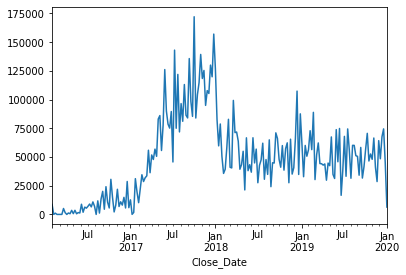

In [39]:
data['Close_Value'].plot()

In [76]:
tra = 
resDiff = sm.tsa.arma_order_select_ic(train_data, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse

ARMA(p,q) = (6, 6) is the best.


/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [93]:
tr_start,tr_end = '2016-02-01','2019-07-01'
te_start,te_end = '2019-07-02','2020-01-06'
tra = train_data
tes = test_data

In [137]:
arima = sm.tsa.statespace.SARIMAX(tra,order=(6,1,6),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Close_Value   No. Observations:                  179
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -1930.665
Date:                Thu, 13 Aug 2020   AIC                           3887.330
Time:                        21:23:03   BIC                           3928.172
Sample:                    02-01-2016   HQIC                          3903.902
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2908      0.840     -1.537      0.124      -2.936       0.355
ar.L2         -1.1781      1.921     -0.613      0.540      -4.943       2.587
ar.L3         -0.4349      2.490     -0.175      0.861      -5.315       4.445
ar.L4          0.4718      2.154      0.219      0.827      -3.749       4.693
ar.L5          0.3292      1.092      0.301      0.763      -1.812       2.470
ar.L6          0.2364      0.262      0.901      0.367      -0.278       0.750
ma.L1          0.5018      0.841      0.597      0.551      -1.147       2.151
ma.L2          0.3223      1.285      0.251      0.802      -2.197       2.841
ma.L3         -0.2845      1.109     -0.256      0.798      -2.459       1.890
ma.L4         -0.6147      0.525     -1.172      0.241      -1.643       0.414
ma.L5          0.0822      0.377      0.218      0.827      -0.657       0.821
ma.L6         -0.0377      0.369     -0.102      0.918      -0.760       0.685
sigma2      4.188e+08    1.5e-07    2.8e+15      0.000    4.19e+08    4.19e+08
===================================================================================
Ljung-Box (Q):                       35.90   Jarque-Bera (JB):                25.09
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               4.66   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+32. Standard errors may be unstable.
"""

MSE LOSS

In [138]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:359437407.94069034


In [139]:
df = pd.concat([pred, tes], axis=1)

<AxesSubplot:>

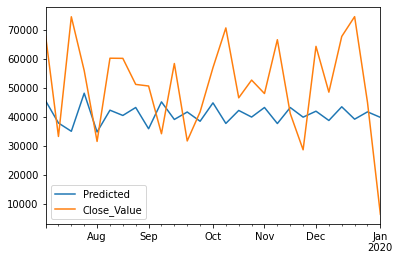

In [143]:
df.rename(columns={0:'Predicted'}).plot()

MONTH OF JULY

In [147]:
month = arima.predict('2019-07-02','2019-08')[1:]
month.sum()

155661.1152580671

QUATERLY

In [150]:
quater1 = arima.predict('2019-01','2019-04')[1:]
quater2 = arima.predict('2019-04','2019-07')[1:]
quater3 = arima.predict('2019-07','2019-10')[1:]
quater4 = arima.predict('2019-10','2019-12')[1:]
print(quater1.sum(),quater2.sum(),quater3.sum(),quater4.sum())

881486.4232928734 614551.1369304352 571889.161871907 325492.30399872916


YEARLY

In [151]:
yearly = arima.predict('2019-01','2019-12')[1:]
yearly.sum()

2207081.186687443